In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from uncertainties import correlated_values
import uncertainties.unumpy as unp

eFFORT2 is a python package which implements rates and form factors

In [3]:
from effort2.rates.BtoP_MassEffects import BtoP
from effort2.formfactors.formFactorBtoU import BToPiBCL

First let us initialize the form factor parametrization called BCL (reference needed).
We define the masses of the particles, we use the zero mass approximation, which is good for electrons and muons. This suppresses the Scalar form factor Hscalar (see below)

In [4]:
FF = BToPiBCL(
    m_B=5.27963,
    m_P=0.13957,
    m_L=0
)

There are lattice QCD calculation available for the form factors. To show how everything works let us use them, but this is what we want to fit, together with Vub

In [5]:
lqcd_Bpi = np.load('/home/mapr/projects/eFFORT/eFFORT/data/Bpi_LQCDwithExp_central.npy')
lqcd_Bpi_cov = np.load('/home/mapr/projects/eFFORT/eFFORT/data/Bpi_LQCDwithExp_covariance.npy')

lqcd_Bpi_correlated = correlated_values(lqcd_Bpi, lqcd_Bpi_cov)

The coefficients for the form factors, the first four are for f0, the last 4 are for f+ (which we do not need for our use case, only relevant for the tau lepton).
I use the uncertainties package here sometimes. Check it out, it is awesome for anything related to error propagation.

In [6]:
lqcd_Bpi_correlated

(0.419+/-0.013013835159250654,
 -0.495+/-0.05410791857436428,
 -0.43+/-0.13426180395926365,
 0.22+/-0.33919425479950766,
 0.51+/-0.020808824578408377,
 -1.7+/-0.08254132265877692,
 1.53+/-0.1900873769459146,
 4.52+/-0.8302078598360535)

Set the coefficients in our FF class. The implementation assumes that we have 2x4 coefficients

In [7]:
FF.coefficients = lqcd_Bpi_correlated

Let us plot the two form factors over the q2 range. w and q2 are interchangeable variables. The effort implementation often works with w, but we want to use q2. 
* w: recoil against the hadronic system
* q2: momentum transfer to the lepton system

Exercise: find the equation in the literature. For example search for B->D* l nu 

We get some numerical warnings, sometimes they can be ignored (edge effects in the integration), but make sure everything works when you see them

/home/mapr/projects/eFFORT2/effort2/formfactors/kinematics.py:40: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt( ( (self.m_B**2 + self.m_M**2 - q2)/(2*self.m_B) )**2 - self.m_M**2 )
/home/mapr/projects/eFFORT2/effort2/formfactors/formFactorBtoU.py:111: RuntimeWarning: invalid value encountered in sqrt
  return 2 * self.m_B * self.kinematics.p(q2) / np.sqrt(q2) * self.fplus(q2)
/home/mapr/projects/eFFORT2/effort2/formfactors/formFactorBtoU.py:115: RuntimeWarning: invalid value encountered in sqrt
  return (self.m_B ** 2 - self.m_P ** 2) / np.sqrt(q2) * self.fzero(q2)


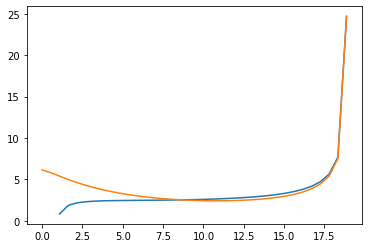

In [8]:
q2 = np.linspace(FF.kinematics.q2(FF.kinematics.w_max), FF.kinematics.q2(FF.kinematics.w_min))

plt.plot(q2, unp.nominal_values(FF.Hzero(q2)))
plt.plot(q2, unp.nominal_values(FF.Hscalar(q2)))

Now let us initialize the rate class which gives the decay rate for B to Pseudoscalar (the pion is a pseudoscalar) semileptonic transitions. Initialize it with the FF and an arbitrary value for Vcb (It should be Vub, something I have to change in the implementation but for all purposes assume it reads Vub although it says Vcb).

In [9]:
Rate = BtoP(FF, Vcb=3.72e-3)

Aaand we plot the normalized rate:

/home/mapr/projects/eFFORT2/effort2/formfactors/kinematics.py:40: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt( ( (self.m_B**2 + self.m_M**2 - q2)/(2*self.m_B) )**2 - self.m_M**2 )
/home/mapr/projects/eFFORT2/effort2/formfactors/formFactorBtoU.py:111: RuntimeWarning: invalid value encountered in sqrt
  return 2 * self.m_B * self.kinematics.p(q2) / np.sqrt(q2) * self.fplus(q2)
/home/mapr/projects/eFFORT2/effort2/formfactors/formFactorBtoU.py:115: RuntimeWarning: invalid value encountered in sqrt
  return (self.m_B ** 2 - self.m_P ** 2) / np.sqrt(q2) * self.fzero(q2)


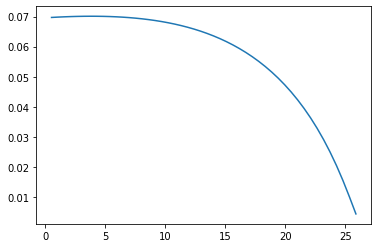

In [10]:
plt.plot(q2, unp.nominal_values(Rate.dGamma_dq2(q2) / Rate.Gamma()))

There is also a function calculating the rate within a given bin:

In [11]:
Rate.DGamma_Dq2(0, 4)

1.1978012884184684e-17+/-1.8767315854475056e-18

In [12]:
Rate.__dict__

{'FF': <effort2.formfactors.formFactorBtoU.BToPiBCL at 0x7f8c42b6cd00>,
 'Vcb': 0.00372,
 'mB': 5.27963,
 'mP': 0.13957,
 'mL': 0,
 'GF': 1.1663787e-05,
 'eta_EW': 1.0066,
 'BR_Dstar_decay': 1,
 'kinematics': <effort2.formfactors.kinematics.Kinematics at 0x7f8c4177f310>,
 'w_min': 1.00000001,
 'w_max': 18.927131937241874}